## Dataset

The dataset used for this project can be found at the following link:
[Electric Chargepoint Analysis 2017 (Domestic)](https://www.data.gov.uk/dataset/5438d88d-695b-4381-a5f2-6ea03bf3dcf0/electric-chargepoint-analysis-2017-domestics)


#### Table of contents


1. [Data Exploration and Preprocessing](#eda)
  
  
    
2. [Visualizations](#visuals)

    
3. [Query with PySpark](#pyspark)

<div class="alert alert-info" style="color:#004643"><h4><b>Data Preprocessing and EDA</b></h4></div> <a id="eda"></a>

##### Import libraries

In [1]:
import matplotlib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import sum as _sum
from pyspark.sql.functions import col, dayofweek, concat, to_timestamp, hour, lit, count


DATA_PATH = './electric-chargepoint-analysis-2017-raw-domestics-data.csv'

In [2]:
# Load data
# Replace 'file_path' with the actual path to your dataset in your folder
df = pd.read_csv(DATA_PATH)

Setup configurations for all plots in this notebook

In [3]:
matplotlib.rcParams['figure.figsize'] = (12, 7)
matplotlib.rcParams['font.size'] = 12

In [4]:
df

,ChargingEvent,CPID,StartDate,StartTime,EndDate,EndTime,Energy,PluginDuration
0,3177742.0,AN21771,2017-12-31,23:59:23,2018-01-01,18:20:23,8.8,18.350000
1,16679268.0,AN04715,2017-12-31,23:59:00,2018-01-01,00:03:00,10.2,0.066667
2,16678965.0,AN04849,2017-12-31,23:59:00,2018-01-01,13:40:00,6.2,13.683333
3,3177556.0,AN21305,2017-12-31,23:57:23,2018-01-01,06:30:23,9.5,6.550000
4,16679057.0,AN08380,2017-12-31,23:57:00,2018-01-01,03:13:00,2.8,3.266667
...,...,...,...,...,...,...,...,...
3176798,10958081.0,AN14208,2017-01-01,00:00:59,2017-01-01,00:59:27,3.7,0.974444
3176799,10955513.0,AN13651,2017-01-01,00:00:52,2017-01-02,02:18:11,6.1,26.288611
3176800,2032525.0,AN22023,2017-01-01,00:00:34,2017-01-01,15:12:06,2.2,15.192222
3176801,2032524.0,AN24284,2017-01-01,00:00:14,2017-01-01,08:00:14,2.8,8.000000


Exploratory Data Analysis (EDA) purposes:

•	`ChargingEvent:`  a unique identifier for each charging event.

•	`CPID:`  an identifier for the charging point or station where the charging event took place. Each charging point or station has its own identifier.

•	`StartDate and StartTime:` These columns together indicate the date and time when the charging event started.

•	`EndDate and EndTime:` These columns together indicate the date and time when the charging event ended.

•	`Energy`: This column represents the amount of energy consumed during the charging event (kWh).

•	`PluginDuration:` This column indicates the duration of time for which the vehicle was plugged into the charging point.

##### Detecting missing data

In [5]:
df.isnull().sum()

ChargingEvent     1
CPID              0
StartDate         0
StartTime         0
EndDate           0
EndTime           0
Energy            0
PluginDuration    0
dtype: int64

In [6]:
# Check for missing items
missing_items = df.isnull().sum().sum()

# Display the number of missing items
print("Number of missing items in the dataset:", missing_items)

Number of missing items in the dataset: 1


In [7]:
df[df['ChargingEvent'].isnull()] # get the record with the missing data

,ChargingEvent,CPID,StartDate,StartTime,EndDate,EndTime,Energy,PluginDuration
1840537,NaN,AN03903,2017-06-30,18:48:00,2017-07-01,09:17:13,5.6,14.486944


##### Handling missing data

Since there is only one missing data in the `ChargingEvent` feature and our dataset is large enough, we can drop it.

In [8]:
df.dropna(inplace=True) # drop the missing data
df.isnull().sum()

ChargingEvent     0
CPID              0
StartDate         0
StartTime         0
EndDate           0
EndTime           0
Energy            0
PluginDuration    0
dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3176802 entries, 0 to 3176802
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   ChargingEvent   float64
 1   CPID            object 
 2   StartDate       object 
 3   StartTime       object 
 4   EndDate         object 
 5   EndTime         object 
 6   Energy          float64
 7   PluginDuration  float64
dtypes: float64(3), object(5)
memory usage: 218.1+ MB


In [10]:
print(len(df.values))
print(len(df.columns))

3176802
8


This Dataset contains 3,176,802 entries and 8 columns (after dropping the missing data).

In [11]:
df['CPID'].value_counts()

CPID
AN05770    1381
AN08160    1316
AN13241    1198
AN17007    1131
AN15224    1095
           ... 
AN21907       1
AN24275       1
AN10602       1
AN18191       1
AN22541       1
Name: count, Length: 25126, dtype: int64

The dataset contains 25,126 unique charging points or stations, with counts associated with each CPID. This data can be used for analyses like identifying frequently used stations, understanding event distribution, or identifying low usage stations for optimization or marketing efforts.

In [12]:
df['StartDate'].value_counts()

StartDate
2017-11-30    13975
2017-12-12    13795
2017-11-29    13640
2017-12-14    13534
2017-11-28    13262
              ...  
2017-05-28     4534
2017-12-25     3838
2017-09-30     3749
2017-04-16     3703
2017-03-31     2622
Name: count, Length: 365, dtype: int64

The data covers a year, from 2017-01-01 to 2017-12-31, with 365 unique dates, with counts indicating the number of charging events on each start date.

In [13]:
df['StartTime'].value_counts()

StartTime
18:08:00    3580
18:10:00    3551
18:04:00    3504
17:55:00    3478
18:16:00    3476
            ... 
04:36:48       1
04:34:41       1
04:18:05       1
03:46:25       1
00:50:12       1
Name: count, Length: 83121, dtype: int64

The data shows charging events occurring at various times throughout the day, with 83,121 unique start times, indicating the granularity of the data.

In [14]:
df['EndDate'].value_counts()

EndDate
2017-12-01    14044
2017-11-30    13854
2017-12-15    13767
2017-12-08    13679
2017-12-12    13654
              ...  
2018-01-27        1
2018-02-01        1
2018-02-12        1
2018-02-04        1
2018-02-10        1
Name: count, Length: 409, dtype: int64

The data from 2017 to 2018 contains 409 unique end dates, indicating the number of charging events. This information can help analyze temporal patterns, activity levels, duration distribution, and anomalies in charging behavior.

In [15]:
df['EndTime'].value_counts()

EndTime
08:02:00    4287
08:03:00    4257
08:01:00    4253
08:04:00    4203
07:59:00    4159
            ... 
03:12:30       1
02:17:42       1
02:43:34       1
03:42:36       1
23:27:34       1
Name: count, Length: 84362, dtype: int64

The data, consisting of 84,362 unique end times, spans a full day and can be used to analyze temporal patterns in charging events, identifying peak completion times and duration distribution.

In [16]:
# Calculate basic statistics
statistics = df[['Energy', 'PluginDuration']].describe()

print(statistics)

             Energy  PluginDuration
count  3.176802e+06    3.176802e+06
mean   9.096554e+00    1.269560e+01
std    7.834977e+00    3.985972e+01
min    1.000000e-02    5.027778e-02
25%    4.100000e+00    2.800000e+00
50%    7.500000e+00    1.075333e+01
75%    1.110000e+01    1.515083e+01
max    9.930000e+01    5.876087e+03


This summary provides insights into the distribution and central tendencies of the numerical attributes in the dataset. It indicates that the majority of charging events consume between 4.10 kWh and 11.10 kWh of energy, with a mean consumption of 9.10 kWh. Similarly, most charging events have plugin durations between 2.80 hours and 15.15 hours, with a mean plugin duration of 12.70 hours.

<div class="alert alert-info" style="color:#004643"><h4><b>Visualizations</b></h4></div> <a id="visuals"></a>

In [17]:

# parse the start date and start time to a timestamp so that we can extract the hours, minutes, etc easily
data = pd.read_csv(DATA_PATH, parse_dates={'Timestamp': ['StartDate', 'StartTime']})

# drop the missing data
data.dropna(inplace=True)

/tmp/ipykernel_74506/961874556.py:2: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  data = pd.read_csv(DATA_PATH, parse_dates={'Timestamp': ['StartDate', 'StartTime']})


In [18]:
# Time-based Analysis
# Extract date and hour from the Timestamp column
data['Date'] = data['Timestamp'].dt.date
data['Hour'] = data['Timestamp'].dt.hour

In [19]:
# Calculate frequency of charging events per day
events_per_day = data.groupby('Date').size()

# Calculate average energy consumption per day
avg_energy_per_day = data.groupby('Date')['Energy'].mean()

# Calculate frequency of charging events per hour
events_per_hour = data.groupby('Hour').size()

# Calculate average energy consumption per hour
avg_energy_per_hour = data.groupby('Hour')['Energy'].mean()

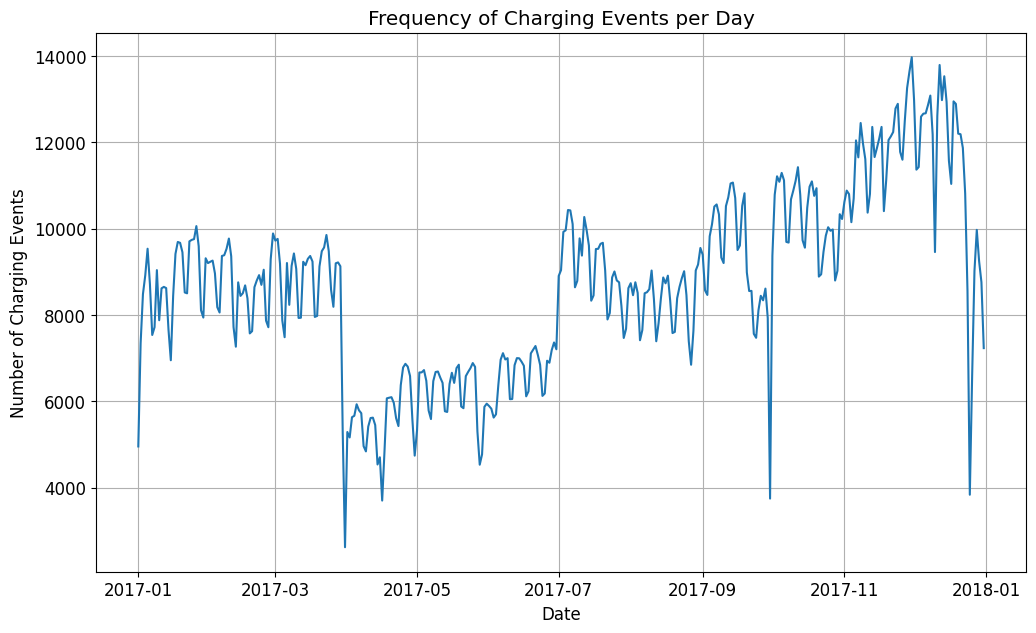

In [20]:
# Visualization
# Plot frequency of charging events per day
events_per_day.plot()
plt.title('Frequency of Charging Events per Day')
plt.xlabel('Date')
plt.ylabel('Number of Charging Events')
plt.grid(True)
plt.show()

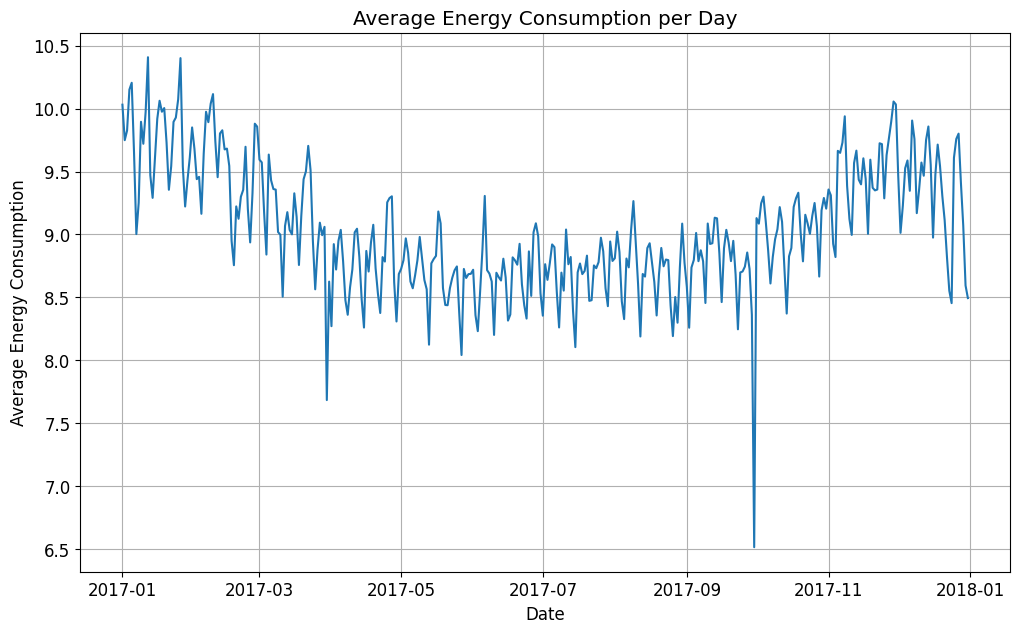

In [21]:
# Plot average energy consumption per day
avg_energy_per_day.plot()
plt.title('Average Energy Consumption per Day')
plt.xlabel('Date')
plt.ylabel('Average Energy Consumption')
plt.grid(True)
plt.show()

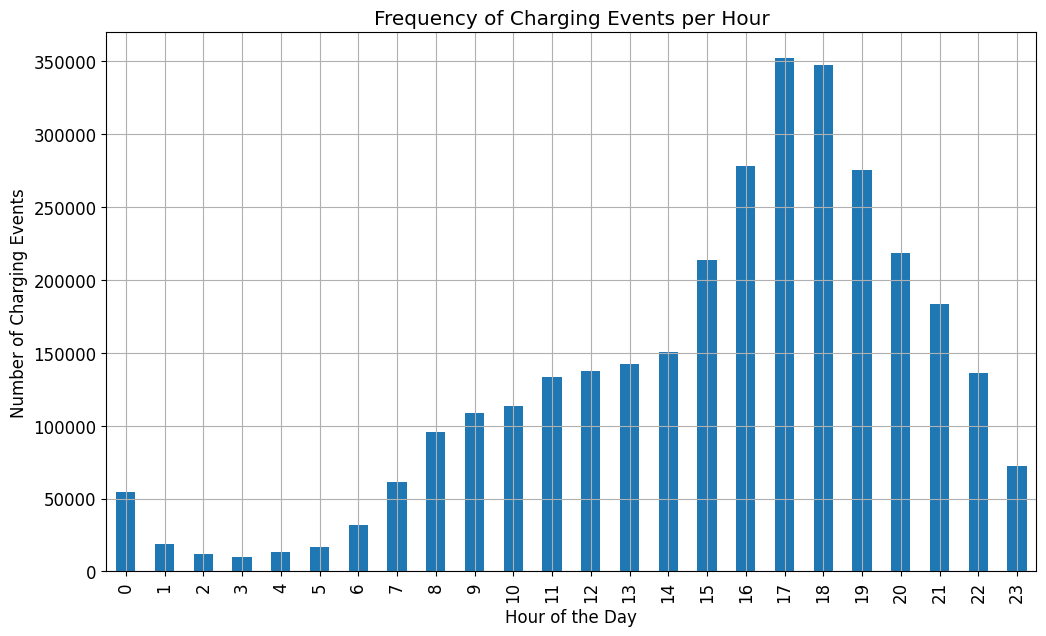

In [22]:
# Plot frequency of charging events per hour
events_per_hour.plot(kind='bar')
plt.title('Frequency of Charging Events per Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Charging Events')
plt.grid(True)
plt.show()

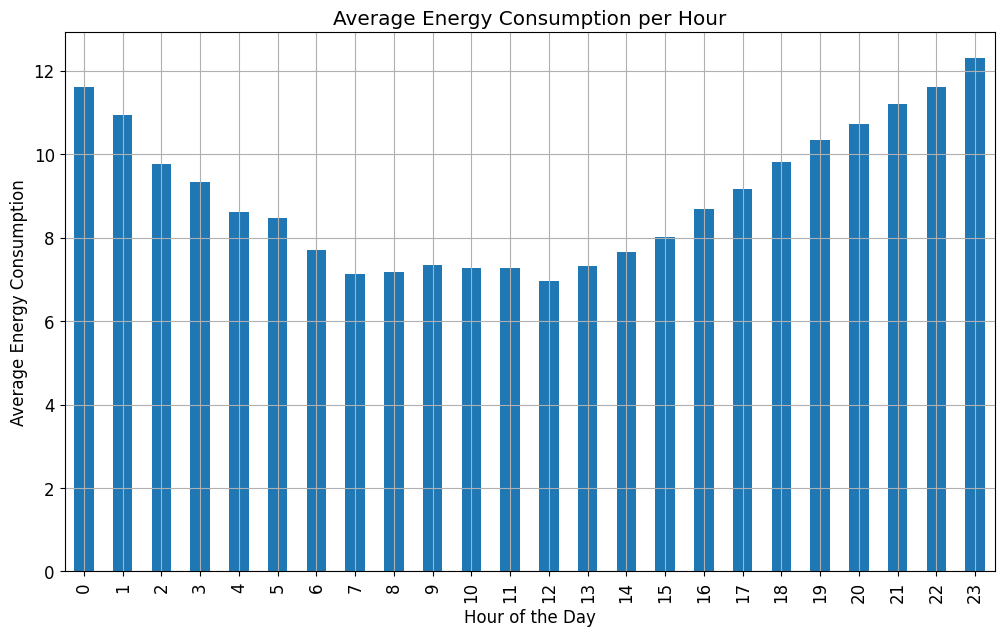

In [23]:
# Plot average energy consumption per hour
avg_energy_per_hour.plot(kind='bar')
plt.title('Average Energy Consumption per Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Energy Consumption')
plt.grid(True)
plt.show()

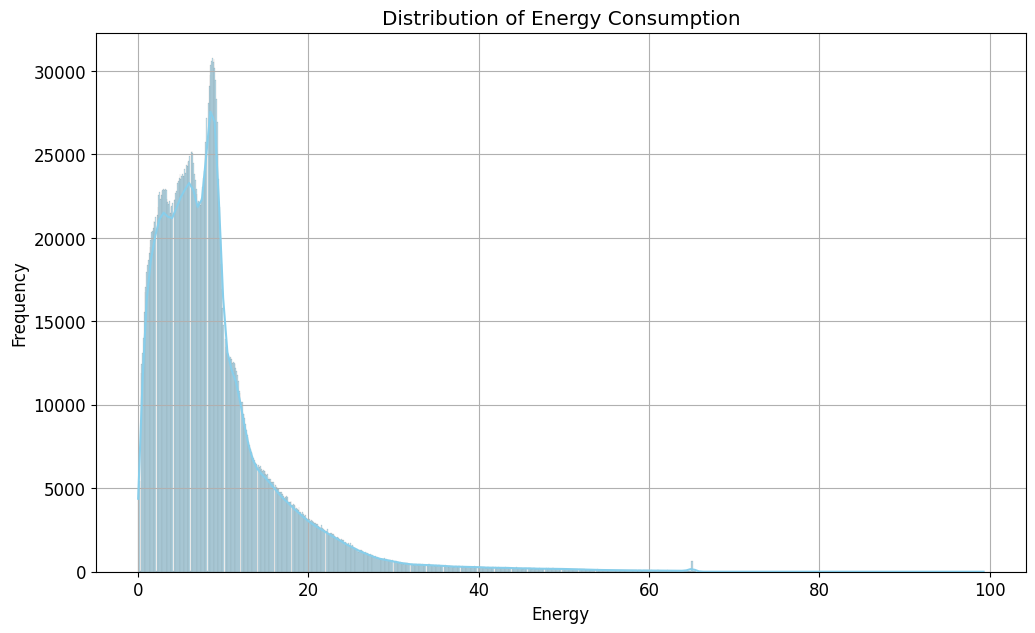

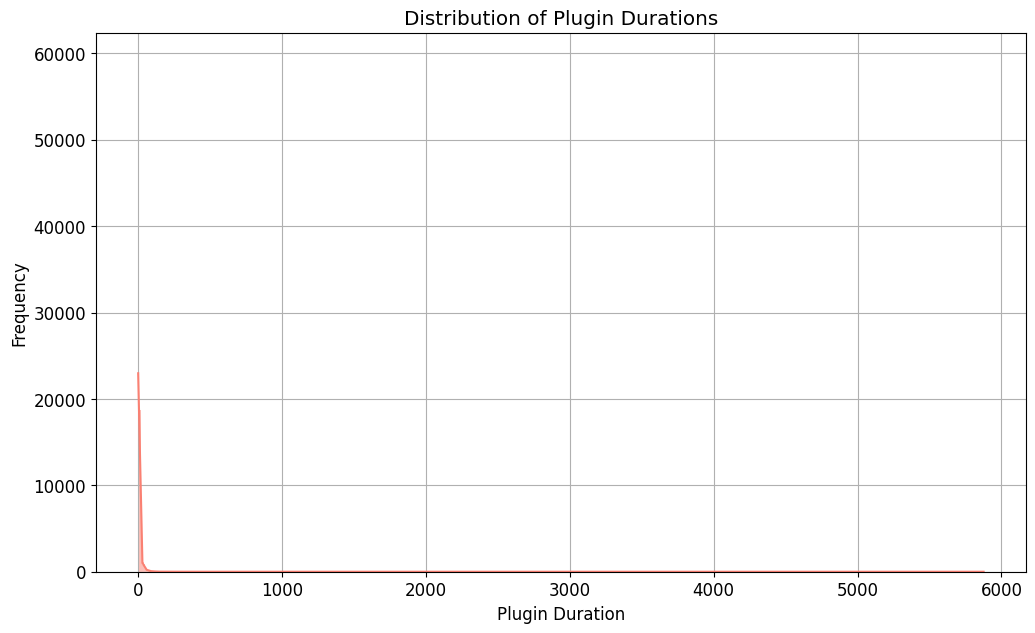

In [24]:
# Plot histograms for energy consumption and plugin durations
sns.histplot(data['Energy'], kde=True, color='skyblue') # type: ignore
plt.title('Distribution of Energy Consumption')
plt.xlabel('Energy')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

sns.histplot(data['PluginDuration'], kde=True, color='salmon') # type: ignore
plt.title('Distribution of Plugin Durations')
plt.xlabel('Plugin Duration')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

**First** histogram. It displays the distribution of energy consumption. The x-axis labeled "Energy" shows the range of energy consumption values. The y-axis labeled "Frequency" shows how many data points fall within each energy consumption range. It shows that the most frequent energy consumption values fall around the 20-40 range on the x-axis. There are also fewer data points scattered throughout the rest of the x-axis.


The **second** graph shows that most plugins have durations less than 3000 milliseconds, with more with shorter durations (marker around 0 milliseconds) than longer ones (marker around 5000 milliseconds).

#### More Visualizations and Analysis

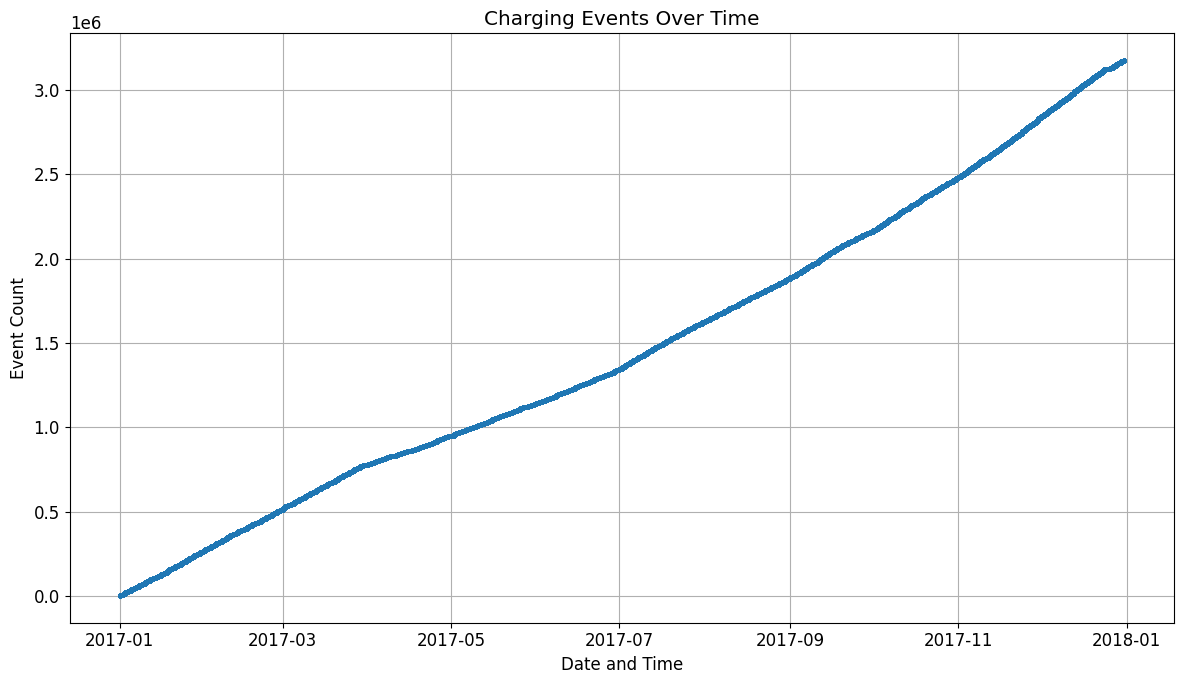

In [25]:
# Convert 'StartDate' column to datetime format
df['StartDate'] = pd.to_datetime(df['StartDate'])

# Sort the DataFrame by 'StartDate' for chronological order
df_sorted = df.sort_values(by='StartDate')

# Plot the charging events against time
plt.plot(df_sorted['StartDate'], range(1, len(df_sorted) + 1), marker='o', linestyle='', markersize=2)
plt.title('Charging Events Over Time')
plt.xlabel('Date and Time')
plt.ylabel('Event Count')
plt.grid(True)
plt.tight_layout()
plt.show()

In [26]:
# Group the data by CPID and calculate the total energy consumption for each station
energy_consumption_by_cpid = df.groupby('CPID')['Energy'].sum()

# Find the CPID with the highest total energy consumption
cpid_highest_consumption = energy_consumption_by_cpid.idxmax()
highest_consumption = energy_consumption_by_cpid.max()

# Find the CPID with the lowest total energy consumption
cpid_lowest_consumption = energy_consumption_by_cpid.idxmin()
lowest_consumption = energy_consumption_by_cpid.min()

# Print the results
print(f"CPID with the highest energy consumption: {cpid_highest_consumption}, Total energy consumption: {highest_consumption} charge units")
print(f"CPID with the lowest energy consumption: {cpid_lowest_consumption}, Total energy consumption: {lowest_consumption} charge units")

CPID with the highest energy consumption: AN22655, Total energy consumption: 14340.65 charge units
CPID with the lowest energy consumption: AN08866, Total energy consumption: 0.1 charge units


In [27]:
# Count the number of charging events for each station ID (CPID)
charging_events_count = df['CPID'].value_counts()

# Find the station ID with the largest number of charging events
station_with_most_events = charging_events_count.idxmax()
most_events_count = charging_events_count.max()

# Find the station ID with the lowest number of charging events
station_with_least_events = charging_events_count.idxmin()
least_events_count = charging_events_count.min()

# Print the results
print(f"Station ID with the largest number of charging events: {station_with_most_events} (Number of events: {most_events_count})")
print(f"Station ID with the lowest number of charging events: {station_with_least_events} (Number of events: {least_events_count})")

Station ID with the largest number of charging events: AN05770 (Number of events: 1381)
Station ID with the lowest number of charging events: AN10814 (Number of events: 1)


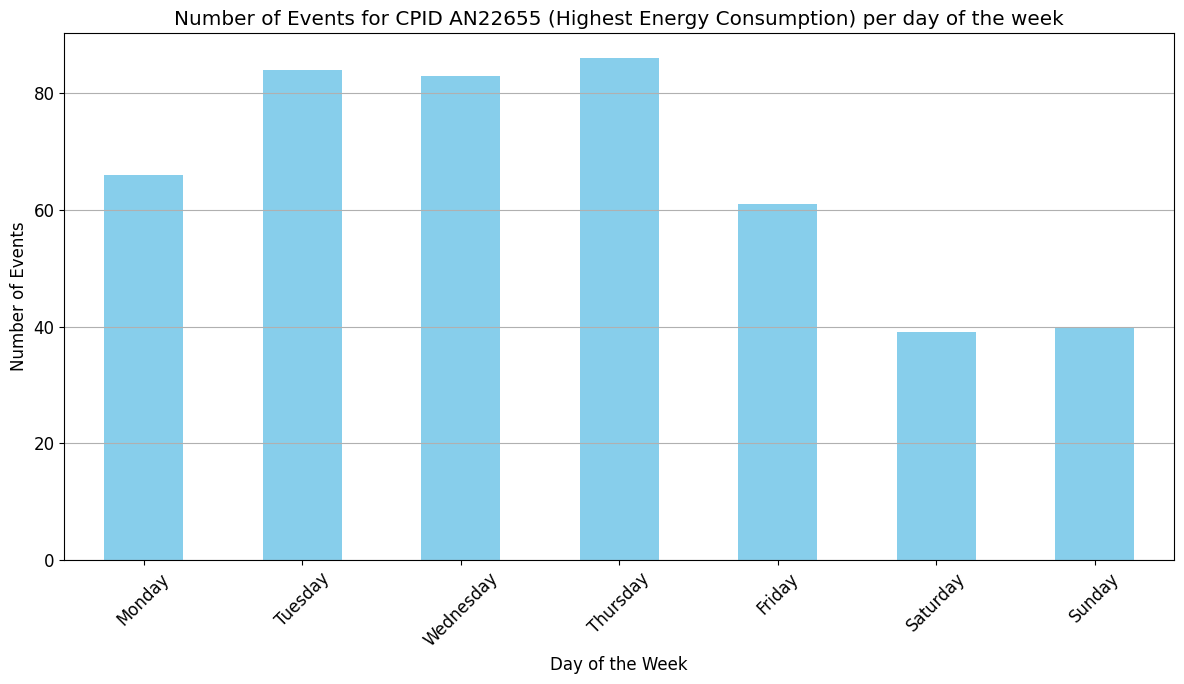

In [28]:
# Filter the DataFrame for the CPID with the highest energy consumption
df_cpid_highest_consumption = df[df['CPID'] == cpid_highest_consumption]

# Count the number of events for each day
events_count_by_day = df_cpid_highest_consumption.groupby(df_cpid_highest_consumption['StartDate'].dt.dayofweek).size()

# Plot the number of events
events_count_by_day.plot(kind='bar', color='skyblue')
plt.title(f'Number of Events for CPID {cpid_highest_consumption} (Highest Energy Consumption) per day of the week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Events')
plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

/tmp/ipykernel_74506/1039031046.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_station_highest_events['DayOfWeek'] = df_station_highest_events['StartDate'].dt.dayofweek


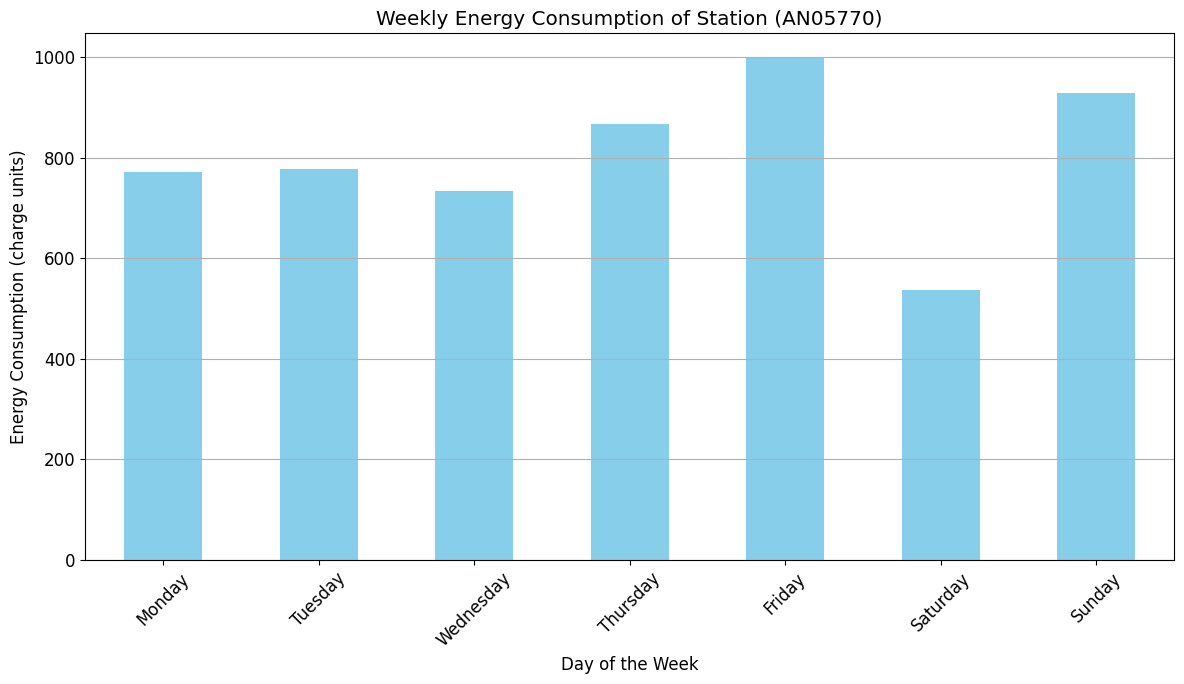

In [29]:
# 1. Filter the DataFrame for the station with the highest number of charging events
df_station_highest_events = df[df['CPID'] == station_with_most_events]

# 2. Extract the day of the week
df_station_highest_events['DayOfWeek'] = df_station_highest_events['StartDate'].dt.dayofweek

# 3. Group the data by the day of the week and sum the energy consumption
energy_consumption_by_day = df_station_highest_events.groupby('DayOfWeek')['Energy'].sum()

# 4. Plot the weekly energy consumption
energy_consumption_by_day.plot(kind='bar', color='skyblue')
plt.title('Weekly Energy Consumption of Station (AN05770)')
plt.xlabel('Day of the Week')
plt.ylabel('Energy Consumption (charge units)')
plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

<div class="alert alert-info" style="color:#004643"><h4><b>Applying PySpark to dataset (Data Query)</b></h4></div><a id="pyspark"></a>

##### `Why PySpark?`
- Performing this analysis with Spark DataFrames the native Spark functions, so it could be executed on multiple nodes of a cluster in parallel and harness the power of the Spark engine.
  
- Since PySpark has support for SQL-like query syntax, anyone with knowledge of SQL can easily pick up the technology which ensures early deployment.
  
- It is a library with support for various popular languages and does not involve the challenging setup we notice in other tools like Hadoop.
  
- PySpark library provides some really helpful methods to convert the dataframe to a convenient format. For example, we can easily convert to a pandas dataframe and perform some visualization as implemented in couple of cells below.

##### Setup a Spark session

In [30]:
spark = SparkSession.builder.master('local[*]').getOrCreate() # type: ignore
spark.conf.set('spark.sql.repl.eagerEval.enabled', True) # Property used to format output tables better

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/01 21:30:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


##### Get information about the spark configurations done above

In [31]:
spark # get information about the spark configurations

##### Load the preprocessed dataset from pandas into spark

In [32]:
spark_df = spark.createDataFrame(df)
spark_df.show() # similar to pandas head() method

24/05/01 21:32:52 WARN TaskSetManager: Stage 0 contains a task of very large size (25461 KiB). The maximum recommended task size is 1000 KiB.
24/05/01 21:32:57 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 0 (TID 0): Attempting to kill Python Worker


+-------------+-------+-------------------+---------+----------+--------+------+------------------+
|ChargingEvent|   CPID|          StartDate|StartTime|   EndDate| EndTime|Energy|    PluginDuration|
+-------------+-------+-------------------+---------+----------+--------+------+------------------+
|    3177742.0|AN21771|2017-12-31 00:00:00| 23:59:23|2018-01-01|18:20:23|   8.8|             18.35|
|  1.6679268E7|AN04715|2017-12-31 00:00:00| 23:59:00|2018-01-01|00:03:00|  10.2|0.0666666666666666|
|  1.6678965E7|AN04849|2017-12-31 00:00:00| 23:59:00|2018-01-01|13:40:00|   6.2|13.683333333333334|
|    3177556.0|AN21305|2017-12-31 00:00:00| 23:57:23|2018-01-01|06:30:23|   9.5|              6.55|
|  1.6679057E7|AN08380|2017-12-31 00:00:00| 23:57:00|2018-01-01|03:13:00|   2.8|3.2666666666666666|
|    3177554.0|AN20124|2017-12-31 00:00:00| 23:56:23|2018-01-01|15:40:23|  25.7|15.733333333333333|
|  1.6678998E7|AN05981|2017-12-31 00:00:00| 23:56:00|2018-01-01|13:48:00|   9.2|13.866666666666667|


##### **Observation**: 
- It is relatively slower loading dataframes into Pyspark compared to load directly from the file such as a csv.

##### Display some information about the dataset

In [33]:
features = spark_df.columns
number_of_rows = spark_df.count()
number_of_features = len(spark_df.columns)

print(f'\nNumber of rows: {number_of_rows:,}')
print(f'Number of features: {number_of_features}')
print(f'Feature Names: {features}')

24/05/01 21:32:59 WARN TaskSetManager: Stage 1 contains a task of very large size (25461 KiB). The maximum recommended task size is 1000 KiB.



Number of rows: 3,176,802
Number of features: 8
Feature Names: ['ChargingEvent', 'CPID', 'StartDate', 'StartTime', 'EndDate', 'EndTime', 'Energy', 'PluginDuration']


##### Get descriptive information about `dataset schema`

In [34]:
spark_df.printSchema()

root
 |-- ChargingEvent: double (nullable = true)
 |-- CPID: string (nullable = true)
 |-- StartDate: timestamp (nullable = true)
 |-- StartTime: string (nullable = true)
 |-- EndDate: string (nullable = true)
 |-- EndTime: string (nullable = true)
 |-- Energy: double (nullable = true)
 |-- PluginDuration: double (nullable = true)



##### Get statistical info about numerical features like `Energy` in our case

In [35]:
spark_df[['Energy']].describe()

24/05/01 21:33:07 WARN TaskSetManager: Stage 4 contains a task of very large size (25461 KiB). The maximum recommended task size is 1000 KiB.
24/05/01 21:33:13 WARN TaskSetManager: Stage 7 contains a task of very large size (25461 KiB). The maximum recommended task size is 1000 KiB.


summary,Energy
count,3176802
mean,9.096553908616203
stddev,7.834976873411528
min,0.01
max,99.3


##### Get the total number of charging events at each charging point location(CPID)

In [36]:
spark_df.groupBy('CPID').count().show()

24/05/01 21:33:19 WARN TaskSetManager: Stage 10 contains a task of very large size (25461 KiB). The maximum recommended task size is 1000 KiB.


+-------+-----+
|   CPID|count|
+-------+-----+
|AN23475|   28|
|AN05752|  223|
|AN24004|  257|
|AN20534|   60|
|AN15457|  352|
|AN03946|  358|
|AN06403|  563|
|AN11888|    4|
|AN02123|  347|
|AN04630|  198|
|AN06580|  399|
|AN10149|  212|
|AN14797|  219|
|AN03789|  265|
|AN20006|  315|
|AN24082|  195|
|AN08465|  188|
|AN03259|  286|
|AN08083|  524|
|AN09251|   78|
+-------+-----+
only showing top 20 rows



##### We can also get the number of unique charging point(CPID)

In [37]:
# Based on pySpark documentation, since "spark_df.groupBy('CPID').count()" returns a DataFrame
# We can check the number of rows using the count() method on the returned DataFrame object
unique_cpids = spark_df.groupBy('CPID').count().count()

print(f"\nThere are {unique_cpids:,} unique charge points across the UK in 2017 captured in the dataset.")

24/05/01 21:33:27 WARN TaskSetManager: Stage 13 contains a task of very large size (25461 KiB). The maximum recommended task size is 1000 KiB.



There are 25,126 unique charge points across the UK in 2017 captured in the dataset.


#### Querying Spark for information
---
This can be achieved by either: 
  
- using pyspark built-in methods like `where()`
- using SQL-like constructed queries which pyspark supports

##### Query spark to get all the charging events at CPID `AN11888`

using built-in methods

In [38]:
spark_df.where(col('CPID') == 'AN11888')

24/05/01 21:33:35 WARN TaskSetManager: Stage 19 contains a task of very large size (25461 KiB). The maximum recommended task size is 1000 KiB.
24/05/01 21:33:37 WARN TaskSetManager: Stage 20 contains a task of very large size (25485 KiB). The maximum recommended task size is 1000 KiB.
24/05/01 21:33:40 WARN TaskSetManager: Stage 21 contains a task of very large size (27968 KiB). The maximum recommended task size is 1000 KiB.
24/05/01 21:33:43 WARN TaskSetManager: Stage 22 contains a task of very large size (25461 KiB). The maximum recommended task size is 1000 KiB.
24/05/01 21:33:44 WARN TaskSetManager: Stage 23 contains a task of very large size (25485 KiB). The maximum recommended task size is 1000 KiB.
24/05/01 21:33:48 WARN TaskSetManager: Stage 24 contains a task of very large size (27968 KiB). The maximum recommended task size is 1000 KiB.


ChargingEvent,CPID,StartDate,StartTime,EndDate,EndTime,Energy,PluginDuration
1.667719E7,AN11888,2017-12-31 00:00:00,19:05:00,2018-01-01,11:08:00,4.1,16.05
1.6663463E7,AN11888,2017-12-30 00:00:00,18:17:00,2017-12-31,11:42:00,9.2,17.416666666666668
1.6531959E7,AN11888,2017-12-21 00:00:00,18:20:00,2017-12-21,21:13:00,9.8,2.8833333333333333
1.6524902E7,AN11888,2017-12-21 00:00:00,12:03:00,2017-12-21,12:55:00,0.9,0.8666666666666667


we can also take advantage of the SQL support in pyspark to write queries

In [39]:
VIEW_NAME = 'SPARK_DATA' # a reusable name for our view

spark_df.createOrReplaceTempView(VIEW_NAME) # Create a temporary view(table) from a DataFrame

spark.sql(f"SELECT * FROM {VIEW_NAME} WHERE CPID = 'AN11888'")

24/05/01 21:33:51 WARN TaskSetManager: Stage 25 contains a task of very large size (25461 KiB). The maximum recommended task size is 1000 KiB.
24/05/01 21:33:53 WARN TaskSetManager: Stage 26 contains a task of very large size (25485 KiB). The maximum recommended task size is 1000 KiB.
24/05/01 21:33:55 WARN TaskSetManager: Stage 27 contains a task of very large size (27968 KiB). The maximum recommended task size is 1000 KiB.
24/05/01 21:33:58 WARN TaskSetManager: Stage 28 contains a task of very large size (25461 KiB). The maximum recommended task size is 1000 KiB.
24/05/01 21:33:59 WARN TaskSetManager: Stage 29 contains a task of very large size (25485 KiB). The maximum recommended task size is 1000 KiB.
24/05/01 21:34:02 WARN TaskSetManager: Stage 30 contains a task of very large size (27968 KiB). The maximum recommended task size is 1000 KiB.


ChargingEvent,CPID,StartDate,StartTime,EndDate,EndTime,Energy,PluginDuration
1.667719E7,AN11888,2017-12-31 00:00:00,19:05:00,2018-01-01,11:08:00,4.1,16.05
1.6663463E7,AN11888,2017-12-30 00:00:00,18:17:00,2017-12-31,11:42:00,9.2,17.416666666666668
1.6531959E7,AN11888,2017-12-21 00:00:00,18:20:00,2017-12-21,21:13:00,9.8,2.8833333333333333
1.6524902E7,AN11888,2017-12-21 00:00:00,12:03:00,2017-12-21,12:55:00,0.9,0.8666666666666667


We also get the same result we got using the built-in method approach earlier

In [40]:
# using spark.sql to check for null values
spark.sql(f"SELECT * FROM {VIEW_NAME} where ChargingEvent IS NULL").show()

24/05/01 21:34:04 WARN TaskSetManager: Stage 31 contains a task of very large size (25461 KiB). The maximum recommended task size is 1000 KiB.
24/05/01 21:34:05 WARN TaskSetManager: Stage 32 contains a task of very large size (25485 KiB). The maximum recommended task size is 1000 KiB.
24/05/01 21:34:08 WARN TaskSetManager: Stage 33 contains a task of very large size (27968 KiB). The maximum recommended task size is 1000 KiB.


+-------------+----+---------+---------+-------+-------+------+--------------+
|ChargingEvent|CPID|StartDate|StartTime|EndDate|EndTime|Energy|PluginDuration|
+-------------+----+---------+---------+-------+-------+------+--------------+
+-------------+----+---------+---------+-------+-------+------+--------------+



##### Get all the records for the month of November (2017-11-01 - 2017-11-30) and order it

In [41]:
spark.sql(
    f"SELECT * FROM {VIEW_NAME} WHERE StartDate >= '2017-11-01' AND StartDate <= '2017-11-30' ORDER BY StartDate"
)

24/05/01 21:34:10 WARN TaskSetManager: Stage 34 contains a task of very large size (25461 KiB). The maximum recommended task size is 1000 KiB.
24/05/01 21:34:17 WARN TaskSetManager: Stage 35 contains a task of very large size (25461 KiB). The maximum recommended task size is 1000 KiB.


ChargingEvent,CPID,StartDate,StartTime,EndDate,EndTime,Energy,PluginDuration
2817378.0,AN19448,2017-11-01 00:00:00,23:59:23,2017-11-02,09:45:23,16.2,9.766666666666667
1.5619455E7,AN00452,2017-11-01 00:00:00,23:54:00,2017-11-02,08:02:00,17.0,8.133333333333333
2817379.0,AN24268,2017-11-01 00:00:00,23:59:23,2017-11-04,14:09:23,7.4,62.16666666666666
1.561961E7,AN13205,2017-11-01 00:00:00,23:59:00,2017-11-02,01:21:00,20.1,1.3666666666666667
1.5619605E7,AN13641,2017-11-01 00:00:00,23:59:00,2017-11-02,10:15:00,31.3,10.266666666666667
1.561927E7,AN08255,2017-11-01 00:00:00,23:59:00,2017-11-02,12:35:00,7.4,12.6
2817421.0,AN24259,2017-11-01 00:00:00,23:58:23,2017-11-08,08:38:23,26.4,152.66666666666666
2817422.0,AN24581,2017-11-01 00:00:00,23:58:23,2017-11-02,07:52:23,8.8,7.9
1.5619566E7,AN13648,2017-11-01 00:00:00,23:58:00,2017-11-02,07:57:00,30.5,7.983333333333333
1.5619567E7,AN04896,2017-11-01 00:00:00,23:58:00,2017-11-02,18:01:00,5.4,18.05


##### Calculate the total energy consumed per month in charging the vehicles

In [42]:
query = f"SELECT month(EndDate) AS Month, ROUND(sum(Energy), 4) AS Total_Energy FROM {VIEW_NAME} GROUP BY month(EndDate) ORDER BY CAST(Total_Energy AS numeric)"
monthly_energy_consumption = spark.sql(query)

monthly_energy_consumption

24/05/01 21:34:23 WARN TaskSetManager: Stage 36 contains a task of very large size (25461 KiB). The maximum recommended task size is 1000 KiB.
24/05/01 21:34:30 WARN TaskSetManager: Stage 39 contains a task of very large size (25461 KiB). The maximum recommended task size is 1000 KiB.


Month,Total_Energy
4,1458376.66
5,1667175.58
6,1731709.95
8,2257232.15
2,2315839.95
7,2431598.34
3,2496971.23
9,2504342.24
1,2612435.94
10,2790207.14


##### Plot the data generated for easier interpretation

24/05/01 21:34:36 WARN TaskSetManager: Stage 42 contains a task of very large size (25461 KiB). The maximum recommended task size is 1000 KiB.


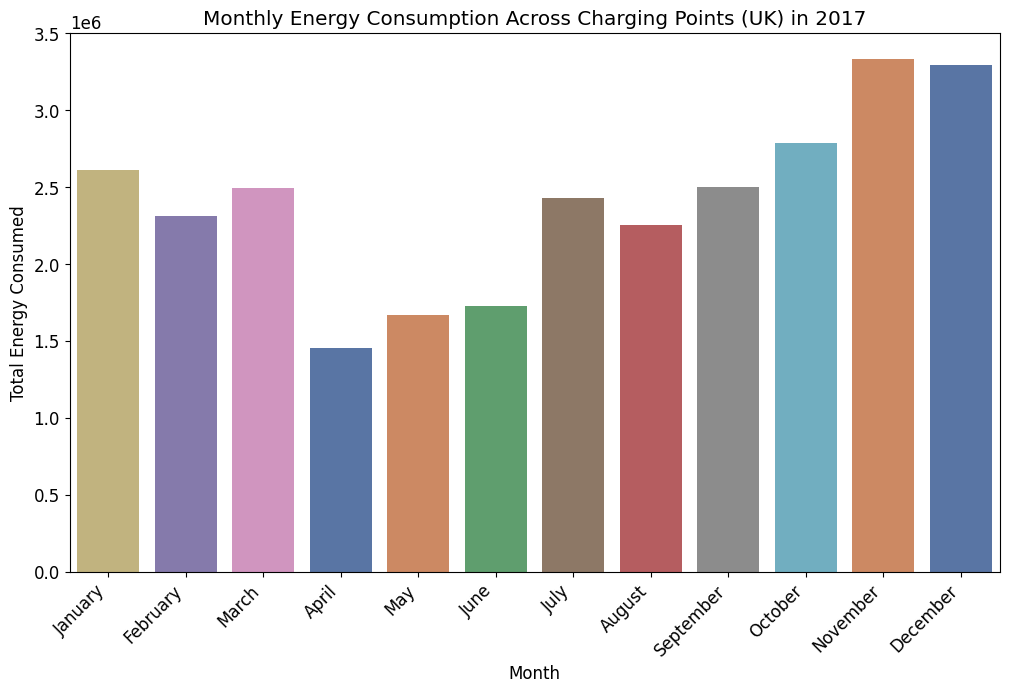

In [43]:
pandas_monthly_energy = monthly_energy_consumption.toPandas() # convert to pandas dataframe

x_label_names = ['January', 'February', 'March', 'April', 'May', 'June',
                 'July', 'August', 'September', 'October', 'November', 'December']

palette = sns.color_palette('deep', pandas_monthly_energy.shape[0])

sns.barplot(x='Month', y='Total_Energy',
            data=pandas_monthly_energy, palette=palette, hue='Total_Energy')
plt.title('Monthly Energy Consumption Across Charging Points (UK) in 2017')
plt.xlabel('Month');
plt.xticks(range(len(x_label_names)), x_label_names, rotation=45, ha='right');
plt.ylabel('Total Energy Consumed');
plt.legend([],[], frameon=False); # remove legend since palette gives a warning without specifying the hue
plt.show();

In [44]:
pandas_monthly_energy

,Month,Total_Energy
0,4,1458376.66
1,5,1667175.58
2,6,1731709.95
3,8,2257232.15
4,2,2315839.95
5,7,2431598.34
6,3,2496971.23
7,9,2504342.24
8,1,2612435.94
9,10,2790207.14


##### **Observation**
- The months of `October`, `November`, and `December` have higher energy consumptions used which could be as a result of the festive season when people have more free time to travel and visit loved ones.

24/05/01 21:34:44 WARN TaskSetManager: Stage 50 contains a task of very large size (25461 KiB). The maximum recommended task size is 1000 KiB.


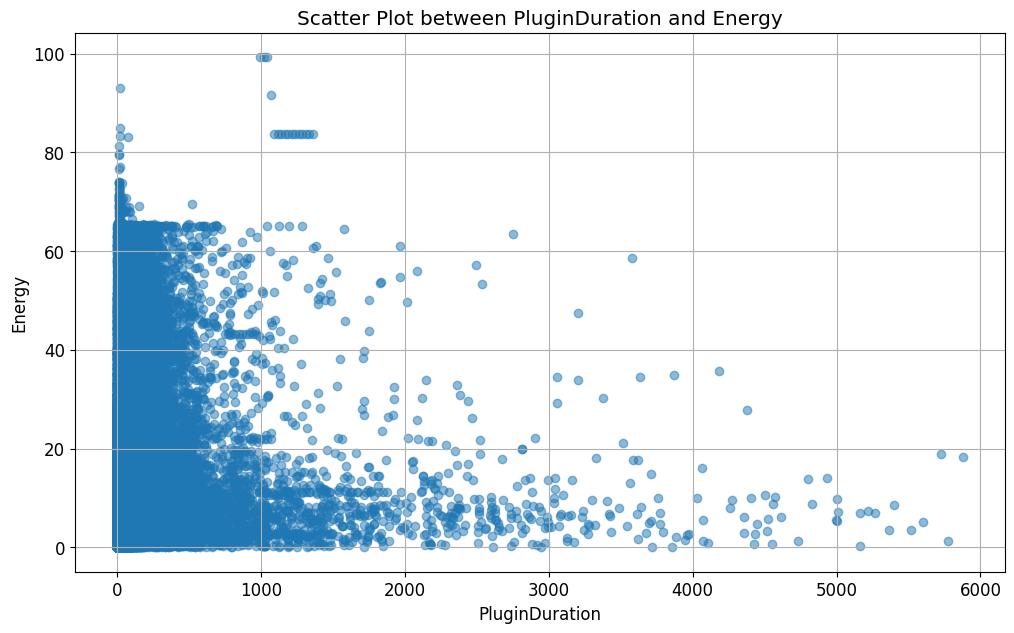

In [45]:
var1 = 'PluginDuration'
var2 = 'Energy'

plot_data = spark_df.select(var1, var2).toPandas()

plt.scatter(plot_data[var1], plot_data[var2], alpha=0.5)
plt.title(f'Scatter Plot between {var1} and {var2}')
plt.xlabel(var1)
plt.ylabel(var2)
plt.grid(True)
plt.show()

In [46]:
spark_df = spark_df.withColumn("StartDate", col("StartDate").cast("date"))

spark_df = spark_df.withColumn("day_of_week", dayofweek("StartDate"))

total_energy = spark_df.groupBy("day_of_week").agg(_sum("Energy").alias("Total_Energy"))

total_energy_pd = total_energy.toPandas()

24/05/01 21:35:22 WARN TaskSetManager: Stage 51 contains a task of very large size (25461 KiB). The maximum recommended task size is 1000 KiB.


In [47]:
days = {1: "Sunday", 2: "Monday", 3: "Tuesday", 4: "Wednesday", 5: "Thursday", 6: "Friday", 7: "Saturday"}
total_energy_pd['day_of_week'] = total_energy_pd['day_of_week'].map(days)

In [48]:
total_energy_pd['day_of_week'] = pd.Categorical(total_energy_pd['day_of_week'],
                                                 categories=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"],
                                                 ordered=True)

In [49]:
total_energy_pd_sum = total_energy_pd.sort_values('day_of_week')

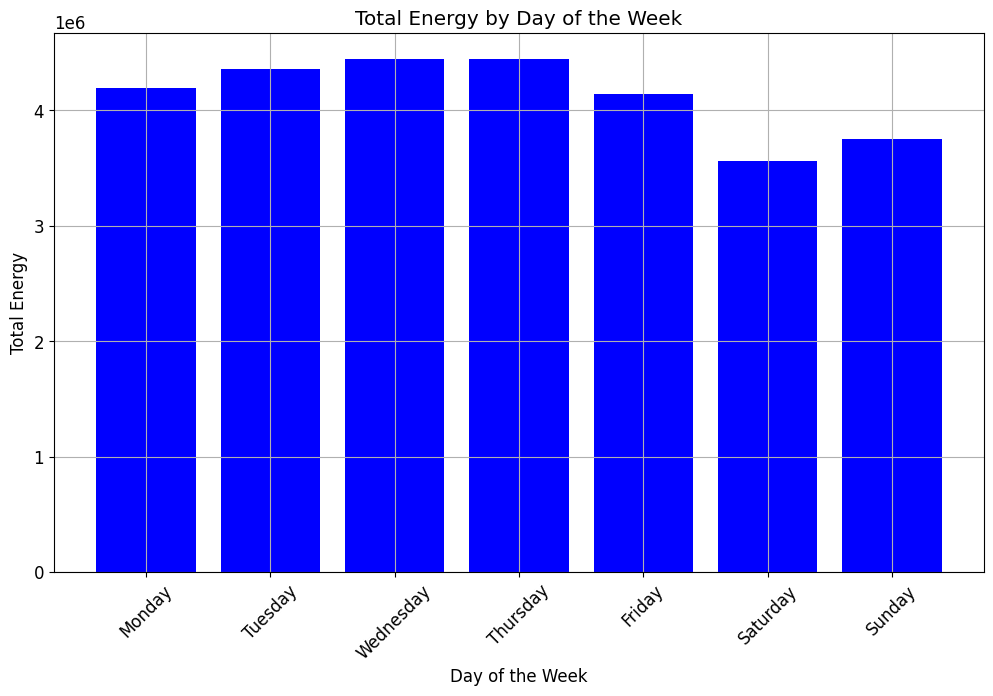

In [50]:
plt.bar(total_energy_pd_sum['day_of_week'], total_energy_pd_sum['Total_Energy'], color='blue')
plt.xlabel('Day of the Week')
plt.ylabel('Total Energy')
plt.title('Total Energy by Day of the Week')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()



In [51]:
spark_df = spark_df.withColumn("TimeDate", to_timestamp(concat(col("StartDate"), lit(" "), col("StartTime")), 'yyyy-MM-dd HH:mm:ss'))

In [52]:
spark_df = spark_df.withColumn("hour", hour("StartTime"))
spark_df = spark_df.withColumn("day_of_week", dayofweek("StartDate"))

In [53]:
hourly_counts = spark_df.groupBy("day_of_week", "hour").agg(count("*").alias("num_occurrences"))

In [54]:
hourly_counts_pd = hourly_counts.toPandas()

24/05/01 21:35:31 WARN TaskSetManager: Stage 54 contains a task of very large size (25461 KiB). The maximum recommended task size is 1000 KiB.


In [55]:
hourly_counts_pd['day_of_week'] = hourly_counts_pd['day_of_week'].map(days)

In [56]:
hourly_counts_pd.sort_values(['day_of_week', 'hour'], inplace=True)

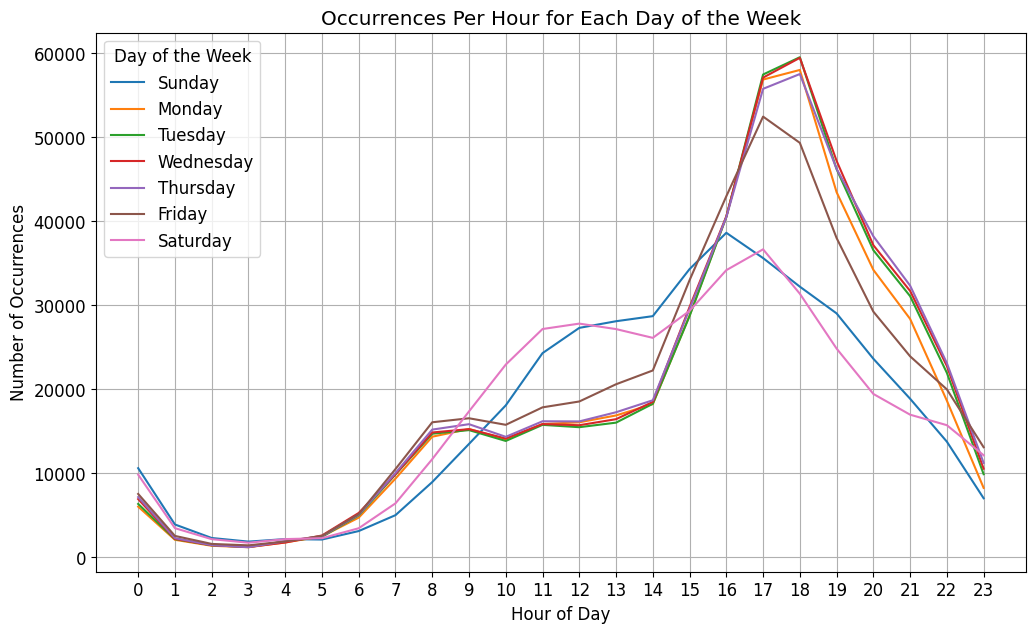

In [57]:

for day in days.values():
    subset = hourly_counts_pd[hourly_counts_pd['day_of_week'] == day]
    plt.plot(subset['hour'], subset['num_occurrences'], label=day)
plt.title('Occurrences Per Hour for Each Day of the Week')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Occurrences')
plt.xticks(range(0, 24))
plt.legend(title='Day of the Week')
plt.grid(True)
plt.show()